# Bike rental project

There are more and more bike rental services blah blah blah... It would be great to be able to predict the amount of bike rent based on whether and time of the year. Let's do this then !

## Data exploration
Let's first examine the data we are working with

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
day = pd.read_csv("day.csv")
hour = pd.read_csv("hour.csv")
hour.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
# formating date and time properly
hour.head()
hour["dteday"] = pd.to_datetime(hour["dteday"], format= '%Y-%m-%d')
day["dteday"] = pd.to_datetime(day["dteday"], format= '%Y-%m-%d')

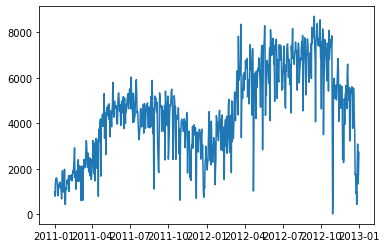

In [4]:
# Let's see how many bikes are rent 
plt.plot(day["dteday"], day["cnt"])

(array([ 13.,  62.,  71.,  73., 122., 137.,  81.,  76.,  79.,  17.]),
 array([  22. ,  891.2, 1760.4, 2629.6, 3498.8, 4368. , 5237.2, 6106.4,
        6975.6, 7844.8, 8714. ]),
 <a list of 10 Patch objects>)

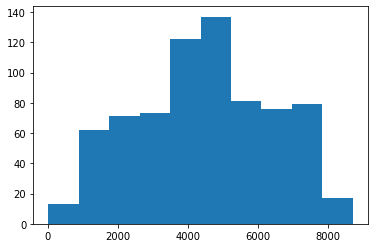

In [5]:
# We now have a better idea, let's plot the histogram to explore our data
plt.hist(day["cnt"])

(array([6972., 3705., 2659., 1660.,  987.,  663.,  369.,  188.,  139.,
          37.]),
 array([  1. ,  98.6, 196.2, 293.8, 391.4, 489. , 586.6, 684.2, 781.8,
        879.4, 977. ]),
 <a list of 10 Patch objects>)

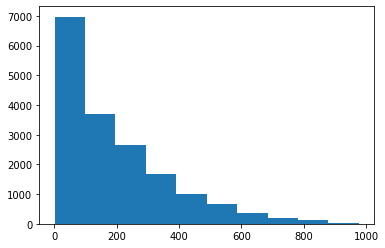

In [6]:
plt.hist(hour["cnt"])

Ok so most of the time, there are around a hundred to two hundred bikes rent each hour, and exceptionnaly it can go up to a thousand bikes rent in an hour ! (let's say on a sunny weekend afternoon :) ).

To have a better understanding of our data, let's explore the correlation between the different features. This will help us select the most important features for our regression model.

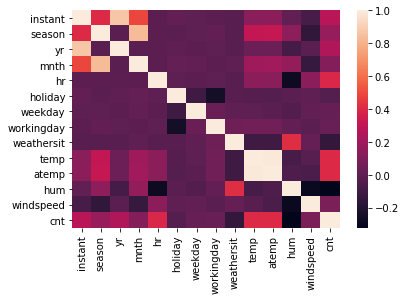

In [7]:
col = hour.columns.tolist()
col = [e for e in col if e not in ("casual","registered")]   # We remove these columns as they are our targets
sns.heatmap(hour[col].corr())

In [8]:
hour.corrwith(hour["cnt"])

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
dtype: float64

## Feature engineering 
Now that we've seen what our data look like, let us create new features that make sense in our study in order to improve our model's predictions.

In [9]:
# Create a time label indicating the time of the day
def assign_label(h):
    if h<=6:
        return 4   # Night
    elif h<=12:
        return 1   # Morning
    elif h<=18:
        return 2   # Afternoon
    else:
        return 3   # Evening

hour["time_label"] = hour["hr"].apply(assign_label)

Here we mainly focused on categorizing the time as it will help our regression, but we could also create new weather features answering question like : was it a snowy day ? a windy one ? Both ?  

## Prediction time !
It's now time to train our model. To do so effectivily, we'll first split our data into two sets : train and test sets. Then we'll use the MAE (mean absolute error) as error metric as it's commun use for regression problems, plus it gives us a real feel of how good a model is.

In [10]:
# First we shuffle our dataset 
shuffled_rows = np.random.permutation(hour.index)
shuffled_df = hour.iloc[shuffled_rows]

# And split it at 80%
cutoff = int(np.round(0.8*shuffled_df.shape[0]))
train = shuffled_df[cutoff:]
test = shuffled_df[:cutoff]

### Using linear regression

In [11]:
# As explained earlier, we'll focus on not too low nor highly correlated values (standard process in a linear regression) 

corrs = hour.corrwith(hour["cnt"])
features = corrs[(abs(corrs)>0.1) & (abs(corrs)<0.65)].index.tolist()
features = [e for e in features if e not in ("instant")]
print(features)


['season', 'yr', 'mnth', 'hr', 'weathersit', 'temp', 'atemp', 'hum', 'time_label']


In [12]:
lr = LinearRegression()
lr.fit(train[features], train["cnt"])
prediction = lr.predict(test[features])

mae = mean_absolute_error(test["cnt"], prediction)
mse = mean_squared_error(test["cnt"], prediction)
print("MAE = {}\nMSE = {}".format(mae,mse))

MAE = 95.22516581687925
MSE = 16138.551816525776


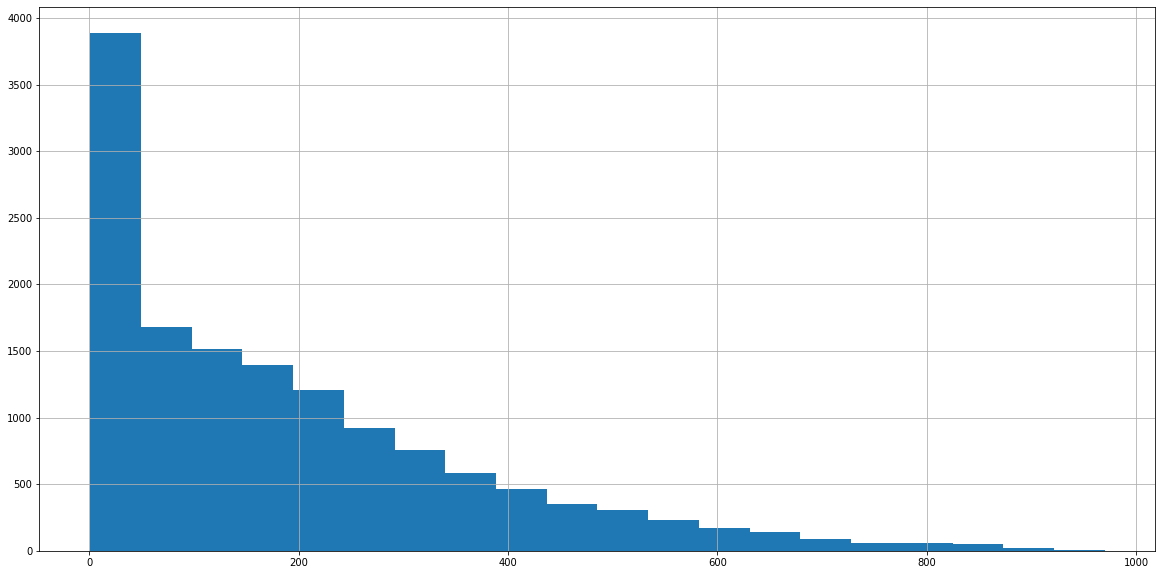

In [13]:
test["cnt"].hist(bins=20, figsize=(20,10))

We based linear regression on features selected according to their correlation factor (high and very low correlated features were removed). With that in mind, **we found a MAE of 96 which is in this context very high** (see histogram above : value for the cnt ranges from 0 to 1000 with most of its values under 500) an mean error of almost 100 is thus **indicating bad predictions.** 

Let's explore other prediction methods, such as decision tree.

### Decision tree

In [14]:
def DecisionTreeModel(n):
    dtr = DecisionTreeRegressor(min_samples_leaf=n)
    dtr.fit(train[features], train["cnt"])
    p = dtr.predict(test[features])

    mae = mean_absolute_error(test["cnt"], p)
    mse = mean_squared_error(test["cnt"], p)
    train_mse = mean_squared_error(train["cnt"], dtr.predict(train[features]))
    return (mae, mse, train_mse)

mae, mse, train_mse = DecisionTreeModel(1)
print("MAE = {}\nMSE = {}\ntrain_MSE = {}".format(mae,mse, train_mse))

MAE = 75.38721858591671
MSE = 15208.796069193699
train_MSE = 21.20512082853855


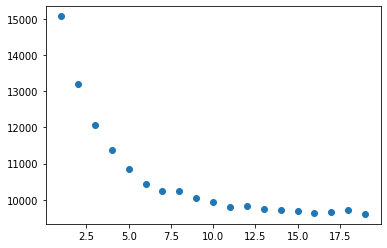

In [15]:
min_samples_split = range(1,20)
mses = []
for i in min_samples_split:
    mses.append(DecisionTreeModel(i)[1])
    
plt.scatter(min_samples_split, mses)

With the random decision tree, we get a better result and could even improve it by tuning its hyperparameter. Another solution is to use a different model : the famous Random Forest !

### Random Forest

In [16]:
def RFmodel(min_samples_leaf=1):
    rfr = RandomForestRegressor(min_samples_leaf=min_samples_leaf)
    rfr.fit(train[features], train["cnt"])
    p = rfr.predict(test[features])

    mae = mean_absolute_error(test["cnt"], p)
    mse = mean_squared_error(test["cnt"], p)
    train_mse = mean_squared_error(train["cnt"], rfr.predict(train[features]))
    return (mae, mse, train_mse)

mae, mse, train_mse = RFmodel()
print("MAE = {}\nMSE = {}\ntrain_MSE = {}".format(mae,mse, train_mse))

MAE = 59.95616795450108
MSE = 8536.676126243321
train_MSE = 1161.0133100015184


ValueError: x and y must be the same size

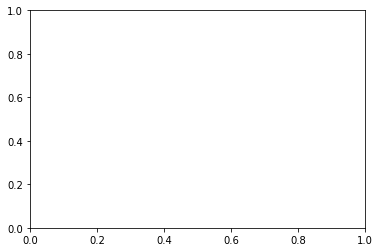

In [17]:
min_samples_leaf = range(1,10)
mses = []
for i in min_samples_leaf:
    mses.append(RFmodel(i)[1])
    
plt.scatter(min_samples_split, mses)

We observe way better results with a Random Forest Regressor model. Here we only tuned the min_samples_leaf hyperparameter, but we could continue with a Grid serach over the differents RFR hyperparameters to even lower the error. 

To sum up, we've tested differents models to predict the number of bike rent based on time and weather conditions. We've seen that the Random Forest has better results than a mere linear regression (which cannot be a surprised) and concluded that a deeper tuning of the model hyperparameter would also improve the results. Another lead would be to engineer other features related to the weather conditions for instance.